In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgbm
import catboost as catb

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [9]:
feats = FeatureUnion(final_transformers)

# feature_processing = Pipeline([('feats', feats)])

In [10]:
def get_classifier_metrics(b, classifier, y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)

    roc_auc = roc_auc_score(y_true=y_test, y_score = classifier.predict_proba(X_test)[:,1])
    return roc_auc, fscore[ix], precision[ix], recall[ix], thresholds[ix]

In [11]:
def get_pred_rates(th, y_test, y_score):
    cnf_matrix = confusion_matrix(y_test, y_score>th)

    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

#     TPR = TP/(TP+FN)
#     FPR = FP/(FP+TN)
#     TNR = TN/(FP+TN)
    
    return TN, FN, TP, FP, cnf_matrix

In [12]:
def profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2):
    total_cost = cost_per_one * (TP + FP) # потратим на возвращение всех предсказанных
    total_rev = rev_per_one * TP # получим с правильно предсказанных
    total_loss = rev_per_one * FN # недополучим с пропущенных, ткк они уйдут
    total_profit = total_rev - total_cost - total_loss
    
    return total_profit

In [13]:
lr = LogisticRegression(random_state = 42)
rf = RandomForestClassifier(random_state = 42)
catboost = catb.CatBoostClassifier(silent = True, random_state = 42)
lgbmc = lgbm.LGBMClassifier(random_state = 42)

models = [lr, rf, catboost, lgbmc]

In [14]:
%%time
res = {}
for model in models:
    classifier = Pipeline([
    ('features',feats),
    ('classifier', model),
    ])
    
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    roc_auc, fscore, precision, recall, threshold = get_classifier_metrics(1, classifier, y_test, y_score)
    TN, FN, TP, FP = get_pred_rates(threshold, y_test, y_score)
    
    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, y_score > threshold)
    plt.figure(figsize=(5, 4))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
    plt.show()
    
    total_profit = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
    
    res['model_' + format(model)] = [roc_auc, fscore, precision, recall, TN, FN, TP, FP, total_profit]

ValueError: too many values to unpack (expected 4)

In [15]:
pd.DataFrame.from_dict(res, orient='index', columns = ['roc_auc', 'fscore', 'precision', 'recall', 'TN', 'FN', 'TP', 'FP', 'total_profit'])

,roc_auc,fscore,precision,recall,TN,FN,TP,FP,total_profit


* catboost не сильно выигрывает по f1 и roc_auc у lgbm, но у lgbm ощутимо выше recall: она пропускает меньше объектов положительного класса, но чаще объявляет ложную тревогу, что может увеличить стоимость затрат на возврат клиентов.
* Предположим, что мы сумеем вернуть каждого верно предсказанного. При стоимости удержания 1 USD и средней ожидаемой прибыли с каждого возвращенного 2 USD (соответственно, и потере с каждого пропущенного отчурнившегося тоже в 2 USD) ни одна из моделей не принесет нам выручки, но на lgbm потери будут минимальны
* при увеличении средней ожидаемой выручки, допустим, до 3 USD lgbm уже выходит в плюс

#### LGBM GridSearch

In [16]:
pipeline_base = Pipeline([
    ('features',feats),
    ('classifier', lgbm.LGBMClassifier(random_state = 42)),
])

In [17]:
params={'classifier__n_estimators':[50, 100, 250, 500],
        'classifier__num_leaves':[11, 21, 31, 51],
        'classifier__max_depth':[-1, 2, 5, 6]
        }

In [18]:
# cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 42)
# grid = GridSearchCV(pipeline_base, params, n_jobs = -1, scoring = 'f1', cv = cv, verbose = 10)

# search = grid.fit(X_train, y_train)


Fitting 25 folds for each of 64 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [19]:
# search.best_params_, search.best_score_

({'classifier__max_depth': -1,
  'classifier__n_estimators': 50,
  'classifier__num_leaves': 21},
 0.5908238612571877)

In [20]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', lgbm.LGBMClassifier(random_state = 42, max_depth = -1, n_estimators = 50, num_leaves = 21)),
])

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [22]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.30312556, 0.20470534, 0.17013452, 0.07156185, 0.03806693,
       0.91237371, 0.0495091 , 0.07350807, 0.18796141, 0.82958118])

In [23]:
roc_auc, fscore, precision, recall, threshold = get_classifier_metrics(1, pipeline, y_test, preds)

In [24]:
fscore, precision, recall, threshold

(0.6536964980544747,
 0.6473988439306358,
 0.6601178781925344,
 0.35752115450230526)

In [25]:
TN, FN, TP, FP, cnf_matrix = get_pred_rates(threshold, y_test, preds)
TN, FN, TP, FP

(1808, 174, 335, 183)

Confusion matrix, without normalization
[[1808  183]
 [ 174  335]]


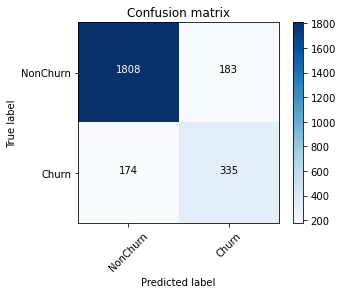

In [26]:
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
plt.show()

In [27]:
total_profit = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
total_profit

-196

Несмотря на то, что мы увеличили f-score c 0.64 до 0.65, экономические метрики модели ухудшились

In [28]:
def get_maxprofit_metrics(b, classifier, y_test, y_score):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    
    profit = []
    for th in thresholds:
        cnf_matrix = confusion_matrix(y_test, y_score > th)

        TN = cnf_matrix[0][0]
        FN = cnf_matrix[1][0]
        TP = cnf_matrix[1][1]
        FP = cnf_matrix[0][1]

        total_profit = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
        profit.append(total_profit)
#     locate the index of the largest f score
    ix = np.argmax(profit)

    return thresholds[ix], profit[ix], fscore[ix], precision[ix], recall[ix]

In [29]:
get_maxprofit_metrics(1, pipeline, y_test, preds)

(0.24242206567964855,
 -190,
 0.6314049586776859,
 0.5449358059914408,
 0.75049115913556)

Мы можем немного улучшить экономические метрики, выбрав трешхолд по максимальной выручке (пожертвовав precision в пользу recall), но в итоге получили модель все равно хуже, чем даже с коробочными настройками

In [30]:
pipeline_base.fit(X_train, y_train)
preds_base = pipeline_base.predict_proba(X_test)[:, 1]

roc_auc, fscore, precision, recall, threshold = get_classifier_metrics(1, pipeline_base, y_test, preds_base)
TN, FN, TP, FP, cnf_matrix = get_pred_rates(threshold, y_test, preds_base)

total_profit = profit_calc(TP, FP, FN, cost_per_one = 1, rev_per_one = 2)
total_profit

-185

In [31]:
get_maxprofit_metrics(1, pipeline_base, y_test, preds_base)

(0.28652171145323346, -181, 0.6422976501305483, 0.5765625, 0.724950884086444)

#### Вывод: при заданных стоимости удержания и ожидаемой выручки с клиента (1 USD и 2 USD соответственно) наша модель не является экономически выгодной